# Loading in Trigger Warnings 

In [1]:
import os

root_dir   = '/n/fs/vai-bwc-scr/'
TW_dir     = os.path.join(root_dir, 'annotations/TW_annotations')
TW_paths   = [os.path.join(TW_dir, x) for x in os.listdir(TW_dir)]
title_path = os.path.join(root_dir, 'annotations/URLs/ids_and_titles.txt')

In [2]:
IDs_to_titles = {}
with open(title_path, 'r') as f:
    for line in f:
        line = line.strip()
        ID, title = line[:9], line[10:]
        title = title.replace(' ', '*')
        title = ''.join(title.split())
        title = title.replace('*', ' ') + '.mp4'
        IDs_to_titles[ID] = title

In [3]:
TWs = {}
for TW_path in TW_paths:
    if not "BWC" in TW_path or '.swp' in TW_path:
        continue
    with open(TW_path, 'r') as f:
        for line in f:
            if 'vimeo' in line: 
                curr_ID = line.strip().split()[0][-9:]
                TWs[curr_ID] = []
            elif line.strip() == '':
                continue
            else:
                line_split = line.strip().split()
                t1, t2 = line_split[:2]
                timeframe = []
                for t in [t1, t2]:
                    minute, second = int(t[:2]), int(t[-2:])
                    timeframe.append(minute*60 + second)
                TWs[curr_ID].append(timeframe)

# Annotating

In [25]:
import mmcv
import random
import matplotlib.pyplot as plt
import cv2
from IPython.display import display, clear_output
from PIL import Image

frames_dir = '/n/fs/visualai-scr/Data/BWC/frames/'

def display_sampled_frames(frame_names):
    images = [Image.open(x) for x in frame_names]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    display(new_im)
    
def filter_tw_frames(TW, vid_len):
    tw_frames = []
    for tw in TW:
        tw_frames += list(range(tw[0], tw[1]))
    tw_frames.append(0)
    tw_frames = set(tw_frames)
    non_tw_frames = list(range(0, vid_len+1))
    for frame in tw_frames:
        non_tw_frames.remove(frame)
    return non_tw_frames

def query_anno(choices):
    no_anno = True
    query = ''
    for i, choice in enumerate(choices):
        query += '{}: {}\t'.format(i, choice)
    query += '\n'
    while no_anno:
        anno = eval(input(query))
        if anno in list(range(len(choices))):
            no_anno = False
        else:
            print('Invalid entry. Please try again.')
    anno = choices[anno]
    return anno

On video 119: Log # 2020-1006 Body Worn Camera  9.mp4


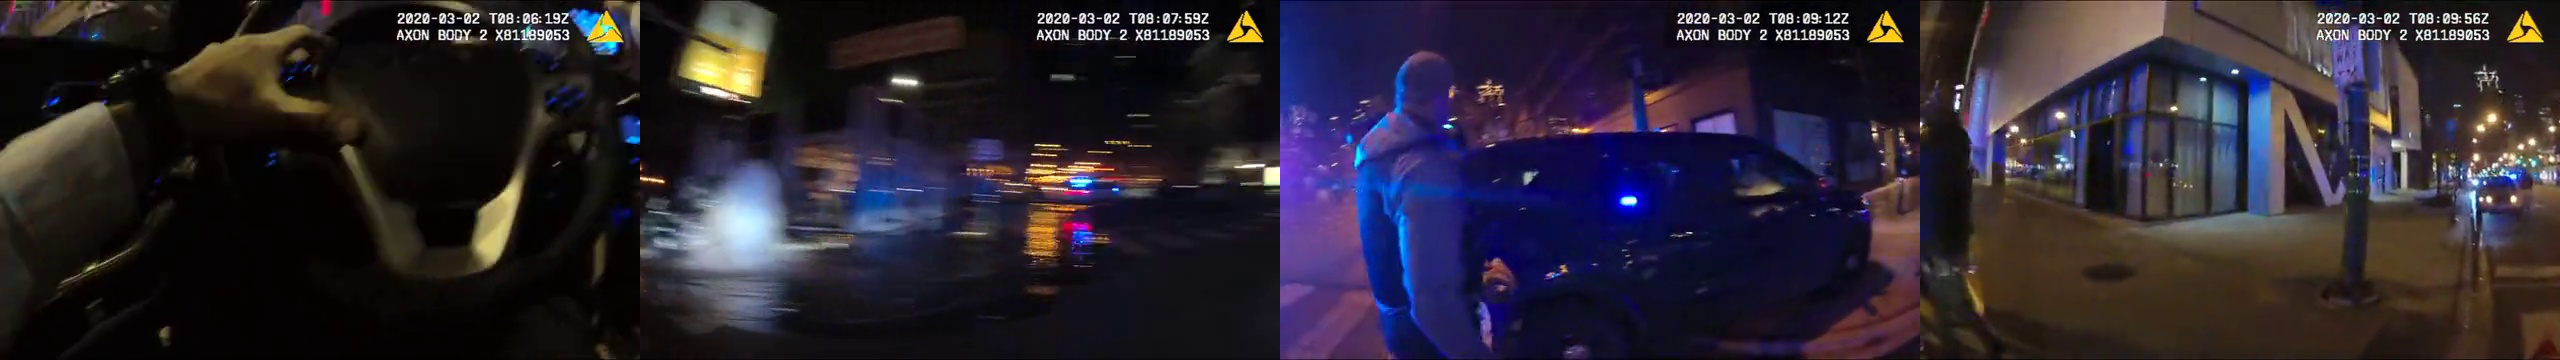

0: Daytime	1: Nighttime	
1
0: Moving	1: Stationary	
0


In [26]:
daynight_annos = {}
moving_annos = {}
for i, ID in enumerate(TWs.keys()):
    clear_output()
    TW = TWs[ID]
    vid_name = IDs_to_titles[ID]
    print('On video {}: {}'.format(i, vid_name))
    vid_dir = os.path.join(frames_dir, vid_name.replace(' ', '_')[:-4])
    vid_len = len(os.listdir(vid_dir))
    non_tw_frames = filter_tw_frames(TW, vid_len)
    sample_frames = random.sample(non_tw_frames, 4)
    sample_frames.sort()
    frame_names = [os.path.join(vid_dir, '{}.jpg'.format(x)) for x in sample_frames]
    display_sampled_frames(frame_names)
    daynight_annos[vid_name] = query_anno(['Daytime', 'Nighttime'])
    moving_annos[vid_name] = query_anno(['Moving', 'Stationary'])

In [30]:
anno_dir = os.path.join(root_dir, 'annotations/categories')
anno_file = os.path.join(anno_dir, 'category_annotations.txt')
with open(anno_file, 'w') as f:
    for key in daynight_annos.keys():
        dn_anno, m_anno = daynight_annos[key], moving_annos[key]
        f.write('{}\t{}\t{}\n'.format(key, dn_anno, m_anno))